In [183]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import diagnostic_plots
import datetime
import random

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from copy import deepcopy
from fancyimpute import MICE as MICE
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor   
from statsmodels.graphics.gofplots import ProbPlot

%matplotlib inline
%config InlineBackend.figure_format = 'svg';

In [145]:
with open('./data/processed/reduced_df2.pkl', 'rb') as picklefile:
    reduced_df2 = pickle.load(picklefile)
y = reduced_df2['price']
X = reduced_df2.drop(('price'), axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)
y_train_log = np.log(y_train)

In [263]:
reduced_df2.shape

(2153, 64)

## Impute the missing data

In [6]:
def standardize_na(df, cols, navalues):
    for col in cols:
        for navalue in navalues:
            df.loc[df[col] == navalue, col] = np.nan
        df[col] = df[col].astype(float)
        #df.loc[df[col] == '123456789.0', col] = np.nan
    return df

In [7]:
col_to_clean = ['city', 'highway', 'engine', 'cylinder', 'horsepower', 'torque']
na_values = ['N/A', '0']

X_train = standardize_na(X_train, col_to_clean, na_values)
#X_train_imputed = pd.DataFrame(data = MICE().complete(X_train.as_matrix()), columns=X_train.columns, index=X_train.index);
imputer = preprocessing.Imputer(missing_values='NaN', strategy ='most_frequent', axis=0)
imputer_fit = imputer.fit(X_train)
X_train_imputed = imputer_fit.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Basic EDA


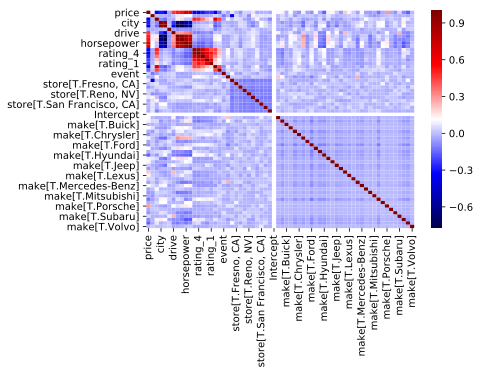

In [8]:
df_train = pd.concat((y_train, X_train), axis=1)
sns.heatmap(df_train.corr(), cmap="seismic");

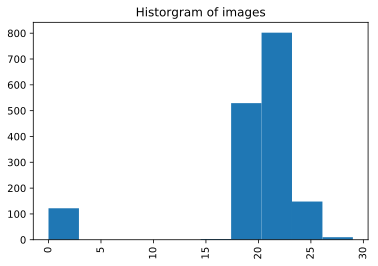

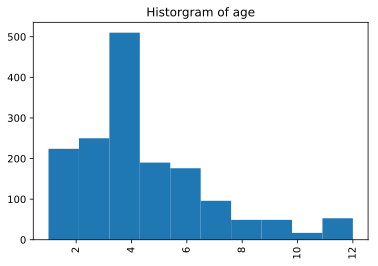

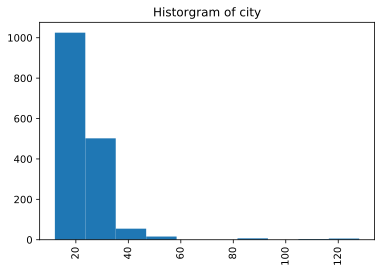

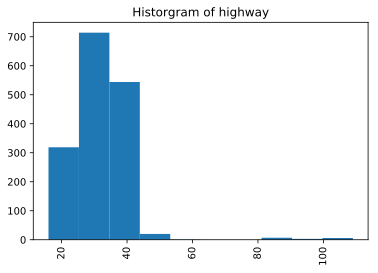

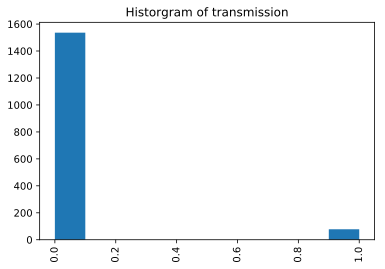

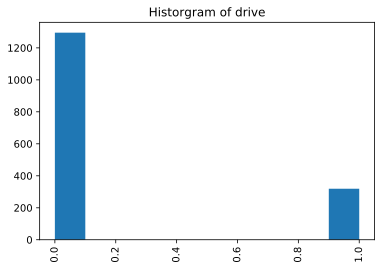

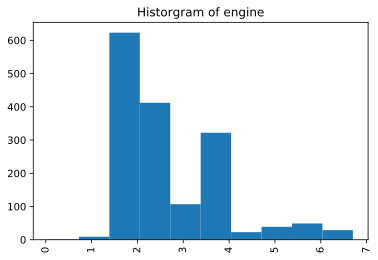

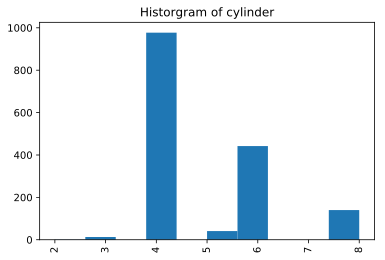

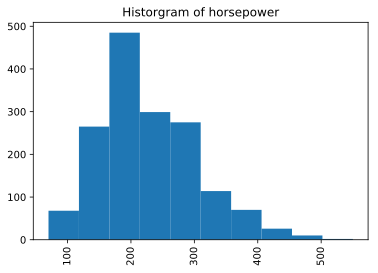

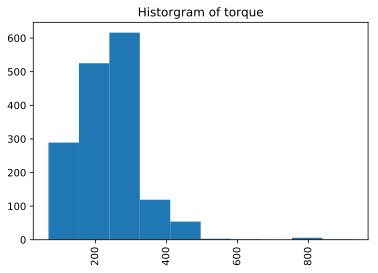

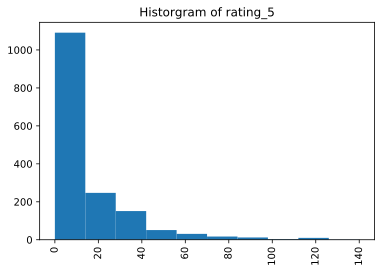

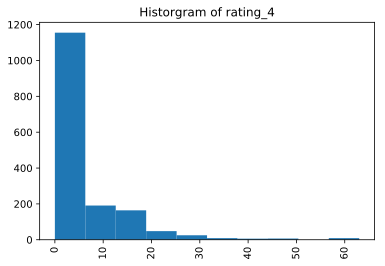

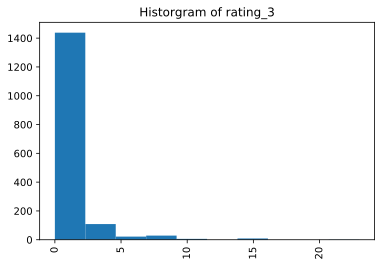

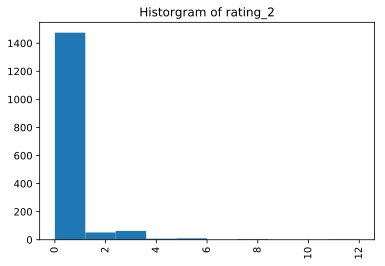

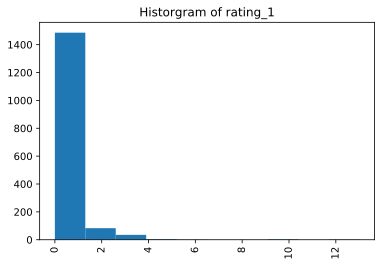

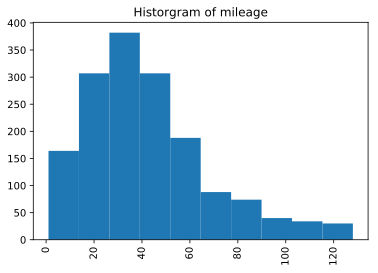

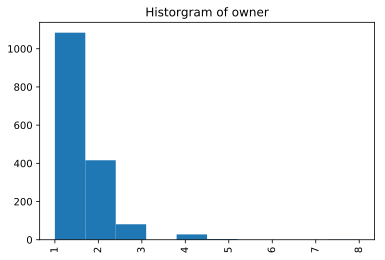

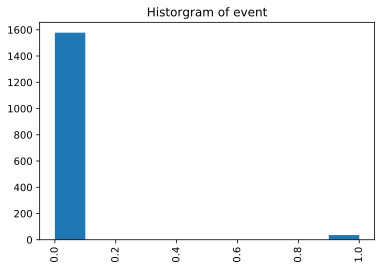

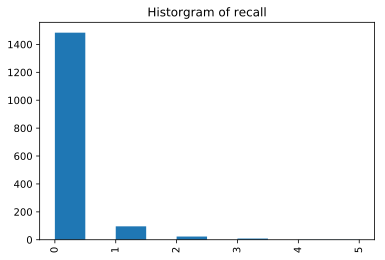

In [262]:
for col in X_train.columns.tolist()[0:19]:
    plt.figure()
    ax = plt.hist(X_train_imputed[col])
    plt.title('Historgram of {}'.format(col))
    plt.xticks(rotation=90)

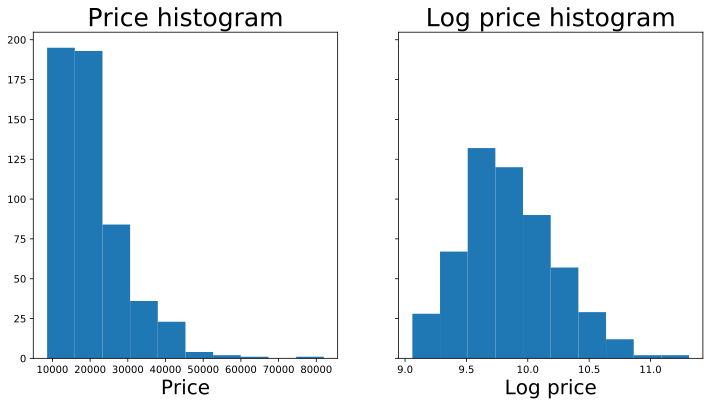

In [302]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True);
plot_lm_0 = plt.figure(1)
plot_lm_0.set_figheight(6)
plot_lm_0.set_figwidth(12)
ax1.hist(y_test);
ax1.set_xlabel('Price', fontsize=20);
ax1.set_title('Price histogram', fontsize=25);
ax2.hist(np.log(y_test));
ax2.set_xlabel('Log price', fontsize=20);
ax2.set_title('Log price histogram', fontsize=25);
f.savefig('price_transformation.png')

## Model 1: Baseline model with all variables

In [267]:
def get_CV_score(df_x, df_y, intercept_present):
    kf = KFold(n=len(df_x), n_folds=5, shuffle=True, random_state=123)
    model_scores =[]
    for train, test in kf:
        X_train_cv = df_x.iloc[train]
        y_train_cv = df_y.iloc[train]
        X_test_cv = df_x.iloc[test]
        y_test_cv = df_y.iloc[test]
        #model = LinearRegression(fit_intercept=intercept_present)
        #model.fit(X_train_cv, y_train_cv)
        if (intercept_present):
            model = sm.OLS(y_train_cv, X_train_cv).fit()
            score = mean_squared_error(model.predict(X_test_cv), y_test_cv)
        else:
            model = sm.OLS(y_train_cv, sm.add_constant(X_train_cv)).fit()
            score = mean_squared_error(model.predict(sm.add_constant(X_test_cv)), y_test_cv)
        model_scores.append(score)
        
        if (intercept_present):
            model = sm.OLS(df_y, df_x).fit()
        else:
            model = sm.OLS(df_y, sm.add_constant(df_x)).fit()
    return np.sqrt(np.mean(model_scores)), model

In [268]:
X_train_imputed.shape

(1614, 63)

In [269]:
model1_score, model1_sm = get_CV_score(X_train_imputed, y_train_log, True)
print ('Model 1 CV RMSE is:', model1_score)

Model 1 CV RMSE is: 0.143897364578


In [270]:
model1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     175.6
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:02:16   Log-Likelihood:                 919.99
No. Observations:                1614   AIC:                            -1714.
Df Residuals:                    1551   BIC:                            -1375.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0021      0.001      3.057      0.002       0.001       0.003
age                           -0.0527      0.003    -19.483      0.000      -0.058      -0.047
city                           0.0111      0.001     11.278      0.000       0.009       0.013
highway                       -0.0173      0.001    -13.184      0.000      -0.020      -0.015
transmission                  -0.0141      0.017     -0.827      0.408      -0.047       0.019
drive                          0.1315      0.011     11.811      0.000       0.110       0.153
engine                         0.0265      0.012      2.288      0.022       0.004       0.049
cylinder                       0.0098      0.009      1.100      0.271      -0.008       0.027
horsepower                     0.0011      0.000      7.932      0.000       0.001       0.001
torque                         0.0010   9.81e-05     10.366      0.000       0.001       0.001
rating_5                       0.0003      0.000      0.513      0.608      -0.001       0.001
rating_4                    8.064e-06      0.001      0.006      0.995      -0.003       0.003
rating_3                       0.0014      0.003      0.444      0.657      -0.005       0.008
rating_2                      -0.0101      0.005     -2.002      0.045      -0.020      -0.000
rating_1                       0.0056      0.005      1.096      0.273      -0.004       0.016
mileage                       -0.0037      0.000    -18.154      0.000      -0.004      -0.003
owner                       3.677e-05      0.006      0.006      0.995      -0.011       0.011
event                          0.0311      0.024      1.283      0.200      -0.016       0.079
recall                         0.0037      0.009      0.400      0.689      -0.015       0.022
store[T.Fremont, CA]           0.0650      0.018      3.569      0.000       0.029       0.101
store[T.Fresno, CA]            0.0337      0.020      1.716      0.086      -0.005       0.072
store[T.Modesto, CA]           0.0361      0.018      2.020      0.044       0.001       0.071
store[T.Pleasanton, CA]        0.0233      0.017      1.354      0.176      -0.010       0.057
store[T.Reno, NV]              0.0104      0.018      0.582      0.561      -0.025       0.046
store[T.Roseville, CA]         0.0317      0.017      1.868      0.062      -0.002       0.065
store[T.Sacramento, CA]        0.0311      0.018      1.697      0.090      -0.005       0.067
store[T.San Francisco, CA]    -0.0015      0.017     -0.087      0.931      -0.036       0.033
store[T.San Jose, CA]          0.0073      0.018      0.405      0.685      -0.028       0.043
store[T.Santa Rosa, CA]       -0.0030      0.017     -0.174      0.862      -0.037       0.031
Intercept                      9.9411      

In [274]:
model1_pvalues = pd.DataFrame(list(zip(model1_sm.pvalues.index.tolist(), model1_sm.params, model1_sm.pvalues)), columns = ['variable', 'coefficient', 'p-value'])
model1_pvalues[model1_pvalues['p-value']<=0.05].sort_values('coefficient', ascending=False)

,variable,coefficient,p-value
29,Intercept,9.941051,0.000000e+00
56,make[T.Porsche],0.372041,6.771306e-11
46,make[T.Land],0.242280,1.848020e-08
47,make[T.Lexus],0.146272,6.793164e-05
5,drive,0.131492,6.889118e-31
43,make[T.Jaguar],0.124554,1.381901e-02
19,"store[T.Fremont, CA]",0.064954,3.695971e-04
31,make[T.BMW],0.063437,4.914130e-02
21,"store[T.Modesto, CA]",0.036142,4.351706e-02
6,engine,0.026477,2.229141e-02


RMSE on test set is 0.136840074783


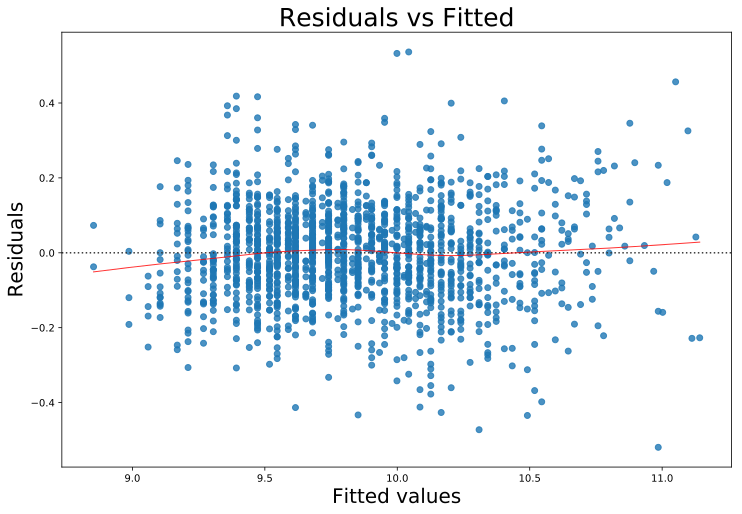

In [315]:
# Predict the RMSE in test data
y_train_predicted_1 = model1_sm.predict(sm.add_constant(X_train_imputed))
score = np.sqrt(mean_squared_error(y_train_predicted_1, y_train_log))
print ('RMSE on test set is', score)

# Plot the residual plot
plot_lm_0 = plt.figure(1)
plot_lm_0.set_figheight(8)
plot_lm_0.set_figwidth(12)
sns.residplot(y_train_log, y_train_predicted_1, 
              lowess=True, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_0.axes[0].set_title('Residuals vs Fitted', fontsize=25)
plot_lm_0.axes[0].set_xlabel('Fitted values', fontsize=20)
plot_lm_0.axes[0].set_ylabel('Residuals',  fontsize=20)
plot_lm_0.savefig('baseline-model-residual.png')

<span style="color:red"> ** The condition number is large, 1.72e+04. This might indicate that there are strong multicollinearity or other numerical problems. **</span>

## Check and rectify multi-collinearity


In [99]:
def remove_high_vif(df, threshold):
    dfx = deepcopy(df)
    col_dropped = []
    check_further = True
    while check_further:
        vif_values = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]        
        vif_table = pd.DataFrame(list(zip(dfx.columns.tolist(), vif_values)), columns=['colname', 'vif'])
        if (vif_table.vif.max()<threshold):
                      check_further = False
                      break
        else:
                      drop_col = vif_table.iloc[vif_table.vif.idxmax(),0]
                      col_dropped.append(drop_col)
                      dfx.drop([drop_col], axis=1, inplace=True)
    print ("remaining variables are: \n", vif_table)
    return dfx, col_dropped

In [100]:
X_train_vif, removed_cols_high_vif = remove_high_vif(X_train_imputed, 5)

remaining variables are: 
                        colname       vif
0                 transmission  1.125096
1                        drive  1.670675
2                     rating_5  4.177393
3                     rating_3  3.029138
4                     rating_2  2.432800
5                     rating_1  2.092454
6                      mileage  4.709829
7                        event  1.078313
8                       recall  1.363672
9         store[T.Fremont, CA]  2.331274
10         store[T.Fresno, CA]  1.639051
11        store[T.Modesto, CA]  2.058714
12     store[T.Pleasanton, CA]  2.279833
13           store[T.Reno, NV]  2.115801
14      store[T.Roseville, CA]  2.379311
15     store[T.Sacramento, CA]  2.047647
16  store[T.San Francisco, CA]  2.246935
17       store[T.San Jose, CA]  2.067183
18     store[T.Santa Rosa, CA]  2.194036
19                make[T.Audi]  1.368197
20                 make[T.BMW]  2.006208
21               make[T.Buick]  1.151406
22            make[T.Cadillac]

In [101]:
print ("variables with high vif are removed:\n", removed_cols_high_vif)

variables with high vif are removed:
 ['Intercept', 'cylinder', 'highway', 'horsepower', 'engine', 'rating_4', 'age', 'images', 'torque', 'city', 'owner']


## Model 2: Fit all remaining variables

In [102]:
model2_score, model2_sm = get_CV_score(X_train_vif, y_train_log, False)
print ('Model 2 CV RMSE is:', model2_score)

Model 2 CV RMSE is: 0.245816991298


In [103]:
model2_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     51.04
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          3.59e-295
Time:                        13:49:40   Log-Likelihood:                 41.404
No. Observations:                1614   AIC:                             23.19
Df Residuals:                    1561   BIC:                             308.7
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.1246      0.054    186.334      0.000      10.018      10.231
transmission                  -0.0705      0.029     -2.448      0.014      -0.127      -0.014
drive                          0.3395      0.017     19.513      0.000       0.305       0.374
rating_5                      -0.0007      0.001     -1.366      0.172      -0.002       0.000
rating_3                      -0.0121      0.005     -2.496      0.013      -0.022      -0.003
rating_2                      -0.0129      0.009     -1.513      0.130      -0.030       0.004
rating_1                      -0.0151      0.009     -1.764      0.078      -0.032       0.002
mileage                       -0.0054      0.000    -20.332      0.000      -0.006      -0.005
event                          0.0183      0.042      0.441      0.659      -0.063       0.100
recall                        -0.0188      0.016     -1.180      0.238      -0.050       0.012
store[T.Fremont, CA]           0.0487      0.030      1.638      0.102      -0.010       0.107
store[T.Fresno, CA]            0.0163      0.034      0.483      0.629      -0.050       0.082
store[T.Modesto, CA]          -0.0282      0.031     -0.924      0.356      -0.088       0.032
store[T.Pleasanton, CA]        0.0145      0.029      0.492      0.623      -0.043       0.072
store[T.Reno, NV]             -0.0104      0.031     -0.341      0.733      -0.070       0.049
store[T.Roseville, CA]         0.0308      0.029      1.058      0.290      -0.026       0.088
store[T.Sacramento, CA]       -0.0068      0.031     -0.216      0.829      -0.068       0.055
store[T.San Francisco, CA]    -0.0705      0.030     -2.358      0.019      -0.129      -0.012
store[T.San Jose, CA]         -0.0554      0.031     -1.795      0.073      -0.116       0.005
store[T.Santa Rosa, CA]       -0.0364      0.030     -1.219      0.223      -0.095       0.022
make[T.Audi]                   0.0440      0.067      0.660      0.509      -0.087       0.175
make[T.BMW]                    0.1228      0.053      2.309      0.021       0.018       0.227
make[T.Buick]                 -0.1836      0.070     -2.615      0.009      -0.321      -0.046
make[T.Cadillac]               0.2556      0.085      3.018      0.003       0.089       0.422
make[T.Chevrolet]             -0.0781      0.054     -1.459      0.145      -0.183       0.027
make[T.Chrysler]              -0.1908      0.068     -2.810      0.005      -0.324      -0.058
make[T.Dodge]                  0.0393      0.055      0.716      0.474      -0.068       0.147
make[T.Fiat]                  -0.3475      0.077     -4.509      0.000      -0.499      -0.196
make[T.Ford]                  -0.1251      0.051     -2.455      0.014      -0.225      -0.025
make[T.GMC]                    0.1955      

This model has much worse RMSE and AIC/BIC scores, though the condition number is slightly lower 

## Model 3: Include polynomial and interaction terms

In [104]:
df_pvalue = pd.DataFrame(list(zip(model1_sm.params.index, model1_sm.pvalues)), columns=['variable', 'pvalue'])
print ('Order the variables by p-value and the top 20 are\n', df_pvalue.sort_values('pvalue').iloc[0:20,:])

Order the variables by p-value and the top 20 are
               variable        pvalue
29           Intercept  0.000000e+00
1                  age  8.497338e-76
15             mileage  6.222137e-67
3              highway  1.063500e-37
5                drive  6.889118e-31
2                 city  2.090033e-28
9               torque  2.165957e-24
61  make[T.Volkswagen]  5.695408e-19
58       make[T.Smart]  1.297382e-16
8           horsepower  4.082829e-15
36       make[T.Dodge]  1.354235e-13
35    make[T.Chrysler]  4.381061e-13
54      make[T.Nissan]  5.222092e-13
38        make[T.Ford]  1.919174e-11
56     make[T.Porsche]  6.771306e-11
41     make[T.Hyundai]  2.231232e-10
45         make[T.Kia]  9.731072e-09
46        make[T.Land]  1.848020e-08
44        make[T.Jeep]  7.711877e-07
37        make[T.Fiat]  1.009497e-05


In [111]:
# Pick the first 7 to include higher term and interaction
significant_var = (df_pvalue[df_pvalue['pvalue']<0.05]
                   .sort_values('pvalue')
                   .variable[1:7]
                   .tolist())

In [114]:
X_train_poly = X_train_imputed[significant_var]
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias = False)
X_train_interact = pd.DataFrame(poly.fit_transform(X_train_poly), columns = poly.get_feature_names(significant_var), index = X_train_poly.index)
tmp = X_train_imputed.drop((significant_var), axis=1)
X_train_int = pd.concat([tmp, X_train_interact], axis=1, join_axes=[tmp.index])

In [119]:
model3_score, model3_sm = get_CV_score(X_train_int, y_train_log, True)
print ('Model 3 CV RMSE is:', model3_score)

Model 3 CV RMSE is: 0.140840139807


In [120]:
model3_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     143.5
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:52:54   Log-Likelihood:                 984.00
No. Observations:                1614   AIC:                            -1802.
Df Residuals:                    1531   BIC:                            -1355.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0017      0.001      2.600      0.009       0.000       0.003
transmission                  -0.0032      0.017     -0.193      0.847      -0.036       0.030
engine                         0.0402      0.012      3.421      0.001       0.017       0.063
cylinder                       0.0088      0.009      0.989      0.323      -0.009       0.026
horsepower                     0.0006      0.000      3.641      0.000       0.000       0.001
rating_5                       0.0004      0.000      0.748      0.454      -0.001       0.001
rating_4                      -0.0007      0.001     -0.568      0.570      -0.003       0.002
rating_3                       0.0020      0.003      0.640      0.522      -0.004       0.008
rating_2                      -0.0112      0.005     -2.294      0.022      -0.021      -0.002
rating_1                       0.0081      0.005      1.645      0.100      -0.002       0.018
owner                         -0.0002      0.006     -0.028      0.978      -0.011       0.011
event                          0.0284      0.024      1.202      0.229      -0.018       0.075
recall                         0.0023      0.009      0.255      0.799      -0.015       0.020
store[T.Fremont, CA]           0.0590      0.018      3.333      0.001       0.024       0.094
store[T.Fresno, CA]            0.0335      0.019      1.746      0.081      -0.004       0.071
store[T.Modesto, CA]           0.0304      0.017      1.744      0.081      -0.004       0.065
store[T.Pleasanton, CA]        0.0253      0.017      1.513      0.130      -0.007       0.058
store[T.Reno, NV]              0.0145      0.017      0.832      0.406      -0.020       0.049
store[T.Roseville, CA]         0.0315      0.017      1.906      0.057      -0.001       0.064
store[T.Sacramento, CA]        0.0254      0.018      1.426      0.154      -0.010       0.060
store[T.San Francisco, CA]     0.0036      0.017      0.213      0.831      -0.030       0.037
store[T.San Jose, CA]          0.0084      0.018      0.477      0.633      -0.026       0.043
store[T.Santa Rosa, CA]        0.0024      0.017      0.142      0.887      -0.031       0.036
Intercept                      9.6177      0.186     51.601      0.000       9.252       9.983
make[T.Audi]                   0.0128      0.040      0.323      0.747      -0.065       0.090
make[T.BMW]                    0.0529      0.032      1.666      0.096      -0.009       0.115
make[T.Buick]                 -0.1214      0.041     -2.981      0.003      -0.201      -0.042
make[T.Cadillac]              -0.0237      0.048     -0.490      0.624      -0.119       0.071
make[T.Chevrolet]             -0.1550      0.031     -4.958      0.000      -0.216      -0.094
make[T.Chrysler]              -0.2963      

### Model 4: Data transformation

In [121]:
X_train_trans = deepcopy(X_train_int)
X_train_trans['torque_log'] = np.log(X_train_trans['torque'])
X_train_trans['horsepower_log'] = np.log(X_train_trans['horsepower'])

In [203]:
def add_luxury(df):
    luxury_cars = (['Lincoln', 'Dodge', 'BMW', 'Infiniti', 'Mercedes-Benz', 'Lexus', 'Audi' ,'GMC', 'Cadillac', 'Jaguar', 
               'Land', 'Porsche'])
    luxury = np.zeros((df.shape[0], 1))
    for col in df.columns:
        make = col.replace("make[T.","").replace("]","")
        if make in luxury_cars:
            luxury = luxury + (np.array(df[col])).reshape(-1,1)
    cadillac = np.zeros((df.shape[0], 1))
    for col in df.columns:
        if ('make' in col):
            cadillac = cadillac + (np.array(df[col])).reshape(-1,1)
    cadillac = 1- cadillac
    df['luxury'] = luxury + cadillac
    return df

In [204]:
X_train_trans = add_luxury(X_train_trans)

In [205]:
X_train_trans['mileage_morethan_100k'] = X_train_trans['mileage'].apply(lambda x:1 if x > 100 else 0)

In [206]:
def add_budget(df):
    budget_cars = (['Smart', 'Pontiac', 'Mercury'])
    budget = np.zeros((df.shape[0], 1))
    for col in df.columns:
        make = col.replace("make[T.","").replace("]","")
        if make in budget_cars:
            budget = budget + (np.array(df[col])).reshape(-1,1)
    df['budget'] = budget
    return df

In [207]:
X_train_trans = add_budget(X_train_trans)

In [208]:
model4_score, model4_sm = get_CV_score(X_train_trans, y_train_log, True)
print ('Model 4 CV RMSE is:', model4_score)

Model 4 CV RMSE is: 0.141690722864


In [209]:
model4_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     138.7
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:57:52   Log-Likelihood:                 986.79
No. Observations:                1614   AIC:                            -1802.
Df Residuals:                    1528   BIC:                            -1338.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0017      0.001      2.532      0.011       0.000       0.003
transmission                  -0.0025      0.017     -0.148      0.882      -0.036       0.031
engine                         0.0374      0.012      3.119      0.002       0.014       0.061
cylinder                       0.0119      0.009      1.265      0.206      -0.007       0.030
horsepower                     0.0004      0.000      0.764      0.445      -0.001       0.001
rating_5                       0.0003      0.000      0.629      0.529      -0.001       0.001
rating_4                      -0.0008      0.001     -0.621      0.535      -0.003       0.002
rating_3                       0.0022      0.003      0.702      0.483      -0.004       0.008
rating_2                      -0.0116      0.005     -2.378      0.018      -0.021      -0.002
rating_1                       0.0086      0.005      1.735      0.083      -0.001       0.018
owner                      -2.669e-06      0.006     -0.000      1.000      -0.011       0.011
event                          0.0266      0.024      1.127      0.260      -0.020       0.073
recall                         0.0009      0.009      0.094      0.925      -0.017       0.019
store[T.Fremont, CA]           0.0578      0.018      3.268      0.001       0.023       0.093
store[T.Fresno, CA]            0.0339      0.019      1.768      0.077      -0.004       0.071
store[T.Modesto, CA]           0.0275      0.017      1.577      0.115      -0.007       0.062
store[T.Pleasanton, CA]        0.0239      0.017      1.430      0.153      -0.009       0.057
store[T.Reno, NV]              0.0139      0.017      0.798      0.425      -0.020       0.048
store[T.Roseville, CA]         0.0285      0.017      1.719      0.086      -0.004       0.061
store[T.Sacramento, CA]        0.0254      0.018      1.424      0.155      -0.010       0.060
store[T.San Francisco, CA]     0.0029      0.017      0.169      0.866      -0.030       0.036
store[T.San Jose, CA]          0.0082      0.018      0.471      0.638      -0.026       0.043
store[T.Santa Rosa, CA]        0.0019      0.017      0.109      0.913      -0.031       0.035
Intercept                      8.6183      0.503     17.134      0.000       7.632       9.605
make[T.Audi]                   0.0157      0.040      0.395      0.693      -0.062       0.093
make[T.BMW]                    0.0527      0.032      1.659      0.097      -0.010       0.115
make[T.Buick]                  0.4673      0.039     12.076      0.000       0.391       0.543
make[T.Cadillac]              -0.0194      0.048     -0.400      0.689      -0.114       0.076
make[T.Chevrolet]              0.4315      0.030     14.323      0.000       0.372       0.491
make[T.Chrysler]               0.2875      

### Model 5: Let Lasso to pick the variables

In [210]:
X_train_lasso = deepcopy(X_train_trans)

In [211]:
kf = KFold(n=len(X_train_lasso), n_folds=5, shuffle=True)
alphas = [10**x for x in range(-12, 5)]
scores = np.zeros((len(alphas),1))

In [212]:
for j in range(len(alphas)):
    kf_score = []
    for train, test in kf:
        X_train_cv = X_train_lasso.iloc[train]
        y_train_cv = y_train_log.iloc[train]
        X_test_cv = X_train_lasso.iloc[test]
        y_test_cv = y_train_log.iloc[test]
        std_scaler = preprocessing.StandardScaler()
        X_train_norm = std_scaler.fit_transform(X_train_cv)
        X_test_norm = std_scaler.transform(X_test_cv)
    
        model =  Lasso(alpha = alphas[j])
        model.fit(X_train_norm, y_train_cv)
        y_test_predict = model.predict(X_test_norm)
        score = mean_squared_error(y_test_predict, y_test_cv)
        kf_score.append(score)
    scores[j] = np.sqrt(np.mean(kf_score))
print ('RMSE for all alpha values \n')
print (pd.DataFrame(list(zip(alphas, scores)), columns=['alpha', 'rmse']))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

RMSE for all alpha values 

           alpha              rmse
0   1.000000e-12  [0.142596944433]
1   1.000000e-11  [0.142596943624]
2   1.000000e-10  [0.142596935531]
3   1.000000e-09  [0.142596854605]
4   1.000000e-08  [0.142596045527]
5   1.000000e-07  [0.142587973483]
6   1.000000e-06  [0.142509044316]
7   1.000000e-05  [0.141897613215]
8   1.000000e-04  [0.141473444406]
9   1.000000e-03  [0.142875931528]
10  1.000000e-02  [0.156356278786]
11  1.000000e-01  [0.248392424729]
12  1.000000e+00  [0.387753924141]
13  1.000000e+01  [0.387753924141]
14  1.000000e+02  [0.387753924141]
15  1.000000e+03  [0.387753924141]
16  1.000000e+04  [0.387753924141]


In [213]:
best_alpha = alphas[scores.argmin()]
print ('best alpha is:', best_alpha, "\nCV RMSE:", (scores.min()))

best alpha is: 0.0001 
CV RMSE: 0.141473444406


In [214]:
std_scaler = preprocessing.StandardScaler()
X_train_norm = std_scaler.fit_transform(X_train_lasso)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train_lasso.columns, index=X_train_lasso.index)

model5 = Lasso(alpha = best_alpha)
model5.fit(X_train_norm, y_train_log)
y_train_predict = model5.predict(X_train_norm)
score = mean_squared_error(y_train_predict, y_train_log)
score = np.sqrt(score)
print ('Model 5 RMSE is:', score)

Model 5 RMSE is: 0.131667917515


/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [312]:
X_train_norm.describe()

,images,transmission,engine,cylinder,horsepower,rating_5,rating_4,rating_3,rating_2,rating_1,...,drive city,drive torque,city^2,city torque,torque^2,torque_log,horsepower_log,luxury,mileage_morethan_100k,budget
count,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,...,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03,1.614000e+03
mean,-2.641423e-16,5.282846e-17,-2.201186e-18,2.509352e-16,-2.971601e-17,3.521897e-17,2.806512e-17,4.512431e-17,-1.320711e-17,1.320711e-17,...,-4.402371e-18,3.301779e-18,-1.430771e-17,1.265682e-16,1.155622e-17,-9.575158e-16,-9.222968e-16,3.742016e-17,9.355039e-17,3.521897e-17
std,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,...,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00,1.000310e+00
min,-3.347756e+00,-2.253470e-01,-2.437283e+00,-2.239270e+00,-2.027238e+00,-7.189818e-01,-6.471157e-01,-4.619441e-01,-4.078178e-01,-4.029536e-01,...,-4.832311e-01,-4.548687e-01,-4.372957e-01,-1.260307e+00,-9.528731e-01,-3.147344e+00,-3.281466e+00,-6.544605e-01,-2.129244e-01,-8.283800e-02
25%,5.202893e-02,-2.253470e-01,-6.715525e-01,-7.006657e-01,-7.168961e-01,-6.674343e-01,-6.471157e-01,-4.619441e-01,-4.078178e-01,-4.029536e-01,...,-4.832311e-01,-4.548687e-01,-2.544660e-01,-5.141876e-01,-5.323396e-01,-6.125719e-01,-6.530884e-01,-6.544605e-01,-2.129244e-01,-8.283800e-02
50%,2.220182e-01,-2.253470e-01,-3.074843e-01,-7.006657e-01,-2.544225e-01,-4.096970e-01,-4.169604e-01,-4.619441e-01,-4.078178e-01,-4.029536e-01,...,-4.832311e-01,-4.548687e-01,-1.508344e-01,-1.672191e-01,-1.003325e-01,2.398968e-01,-9.746348e-02,-6.544605e-01,-2.129244e-01,-8.283800e-02
75%,3.920075e-01,-2.253470e-01,6.937033e-01,8.379390e-01,7.347570e-01,3.119676e-01,2.735055e-01,5.260233e-02,-4.078178e-01,-4.029536e-01,...,-4.832311e-01,-4.548687e-01,-3.203715e-02,2.996778e-01,1.434792e-01,5.577410e-01,8.233499e-01,1.527976e+00,-2.129244e-01,-8.283800e-02
max,1.581932e+00,4.437602e+00,3.606249e+00,2.376544e+00,4.139076e+00,6.497664e+00,6.602776e+00,1.137262e+01,1.143418e+01,1.348009e+01,...,3.838826e+00,6.822280e+00,1.324545e+01,1.243900e+01,1.338504e+01,3.982586e+00,2.745456e+00,1.527976e+00,4.696503e+00,1.207176e+01


In [215]:
df_coef = pd.DataFrame(list(zip(X_train_lasso.columns, model5.coef_)), columns = ['variable', 'coefficient'])
df_coef['abs-coef'] = np.abs(df_coef['coefficient'])
df_coef.sort_values('abs-coef')
print ('Variables we would like to drop are')
print (df_coef[df_coef['abs-coef']<0.01])

Variables we would like to drop are
                      variable  coefficient  abs-coef
0                       images     0.009343  0.009343
1                 transmission     0.000255  0.000255
5                     rating_5     0.003817  0.003817
6                     rating_4    -0.004061  0.004061
7                     rating_3     0.003899  0.003899
9                     rating_1     0.006932  0.006932
10                       owner    -0.000048  0.000048
11                       event     0.003821  0.003821
12                      recall     0.000410  0.000410
14         store[T.Fresno, CA]     0.007427  0.007427
15        store[T.Modesto, CA]     0.007657  0.007657
16     store[T.Pleasanton, CA]     0.006625  0.006625
17           store[T.Reno, NV]     0.002913  0.002913
18      store[T.Roseville, CA]     0.008350  0.008350
19     store[T.Sacramento, CA]     0.007048  0.007048
20  store[T.San Francisco, CA]    -0.000000  0.000000
21       store[T.San Jose, CA]     0.001717  0

In [216]:
cols_to_retain = df_coef[df_coef['abs-coef']>=0.01].variable.tolist()
X_train_lasso_red = X_train_lasso[cols_to_retain]

In [217]:
model5_score, model5_sm = get_CV_score(X_train_lasso_red, y_train_log, False)
print ('Model 5 CV RMSE is:', model5_score)

Model 5 CV RMSE is: 0.140066442121


In [218]:
model5_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     238.6
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:58:39   Log-Likelihood:                 964.34
No. Observations:                1614   AIC:                            -1829.
Df Residuals:                    1564   BIC:                            -1559.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.5571      0.471     18.180      0.000       7.634       9.480
engine                    0.0345      0.011      3.021      0.003       0.012       0.057
cylinder                  0.0173      0.009      1.906      0.057      -0.001       0.035
horsepower                0.0002      0.000      0.516      0.606      -0.001       0.001
rating_2                 -0.0067      0.004     -1.796      0.073      -0.014       0.001
store[T.Fremont, CA]      0.0299      0.011      2.668      0.008       0.008       0.052
make[T.BMW]               0.0373      0.018      2.107      0.035       0.003       0.072
make[T.Chrysler]         -0.1337      0.028     -4.716      0.000      -0.189      -0.078
make[T.Dodge]            -0.2671      0.021    -12.991      0.000      -0.307      -0.227
make[T.Ford]             -0.0488      0.013     -3.820      0.000      -0.074      -0.024
make[T.GMC]              -0.1364      0.033     -4.110      0.000      -0.201      -0.071
make[T.Honda]             0.1623      0.017      9.729      0.000       0.130       0.195
make[T.Hyundai]          -0.0329      0.016     -2.042      0.041      -0.064      -0.001
make[T.Infiniti]         -0.0924      0.025     -3.701      0.000      -0.141      -0.043
make[T.Jaguar]            0.1071      0.042      2.576      0.010       0.026       0.189
make[T.Land]              0.1795      0.033      5.416      0.000       0.115       0.245
make[T.Lexus]             0.1010      0.026      3.894      0.000       0.050       0.152
make[T.Mazda]             0.0761      0.022      3.410      0.001       0.032       0.120
make[T.Mini]              0.0863      0.030      2.919      0.004       0.028       0.144
make[T.Nissan]           -0.0831      0.015     -5.517      0.000      -0.113      -0.054
make[T.Porsche]           0.3580      0.049      7.332      0.000       0.262       0.454
make[T.Subaru]            0.1376      0.030      4.620      0.000       0.079       0.196
make[T.Toyota]            0.1514      0.019      7.851      0.000       0.114       0.189
make[T.Volkswagen]       -0.1601      0.018     -8.888      0.000      -0.195      -0.125
age                       0.0094      0.019      0.506      0.613      -0.027       0.046
mileage                  -0.0066      0.002     -3.839      0.000      -0.010      -0.003
highway                  -0.0249      0.005     -4.548      0.000      -0.036      -0.014
drive                    -0.2380      0.056     -4.279      0.000      -0.347      -0.129
city                      0.0252      0.002     10.281      0.000       0.020       0.030
torque                    0.0040      0.001      4.016      0.000       0.002       0.006
age^2                    -0.0012      0.001     -2.013      0.044      -0.002   -3.12e-05
age highway            

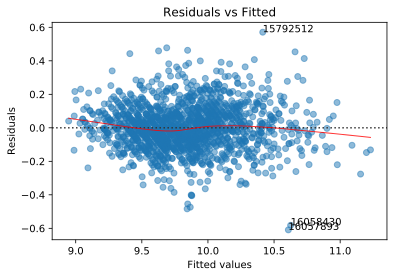

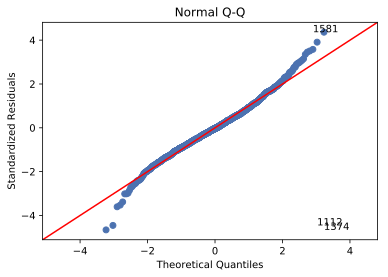

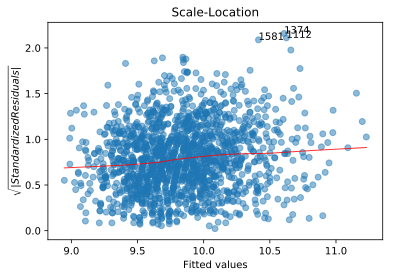

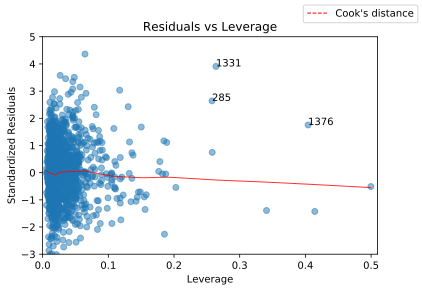

In [246]:
diagnostic_plots.diagnostic_plots(X_train_lasso_red, y_train_log)

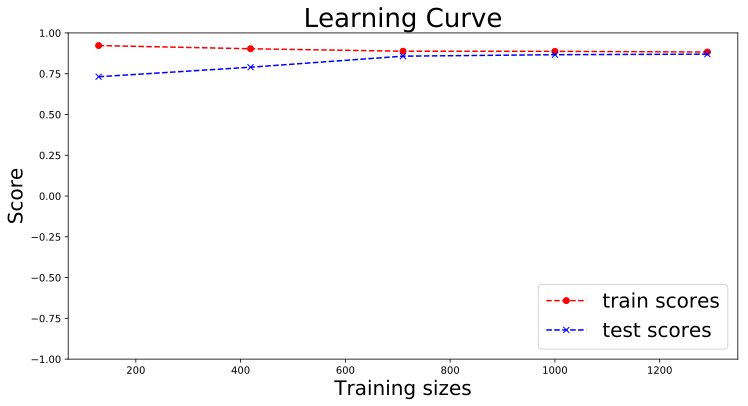

In [304]:
from sklearn.model_selection import learning_curve
# Make a model, say quadratic

lr = LinearRegression()
model5_fit = lr.fit(X_train_lasso_red, y_train_log)
train_sizes, train_scores, test_scores = learning_curve(model5_fit, X_train_lasso_red, y_train_log, cv=5)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df  = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

plot_lm_0 = plt.figure(1)
plot_lm_0.set_figheight(6)
plot_lm_0.set_figwidth(12)
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right', fontsize=20)
plt.xlabel('Training sizes', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Learning Curve', fontsize=26)
plt.ylim(-1,1)
plt.savefig('learning_curve.png')

# Validate the model on test set!

In [157]:
# Apply log transformation
y_test_log = np.log(y_test)

In [158]:
# Impute missing data
X_test = standardize_na(X_test, col_to_clean, na_values)
X_test_imputed = imputer_fit.transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [159]:
# Incluse polynomial and interaction terms
X_test_poly = X_test_imputed[significant_var]
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias = False)
X_test_interact = pd.DataFrame(poly.fit_transform(X_test_poly), columns = poly.get_feature_names(significant_var), index = X_test_poly.index)
tmp = X_test_imputed.drop((significant_var), axis=1)
X_test_int = pd.concat([tmp, X_test_interact], axis=1, join_axes=[tmp.index])

In [220]:
# Introduce transformations
X_test_trans = deepcopy(X_test_int)
X_test_trans['torque_log'] = np.log(X_test_trans['torque'])
X_test_trans['horsepower_log'] = np.log(X_test_trans['horsepower'])
X_test_trans = add_luxury(X_test_trans)
X_test_trans['mileage_morethan_100k'] = X_test_trans['mileage'].apply(lambda x:1 if x > 100 else 0)
X_test_trans = add_budget(X_test_trans)

In [221]:
# Normalize test data
X_test_lasso = deepcopy(X_test_trans)
X_test_norm = std_scaler.transform(X_test_lasso)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test_lasso.columns, index=X_test_lasso.index)

In [222]:
# Only retain the columns which has absolute value of coefficient less than 0.01
X_test_lasso_red = X_test_lasso[cols_to_retain]

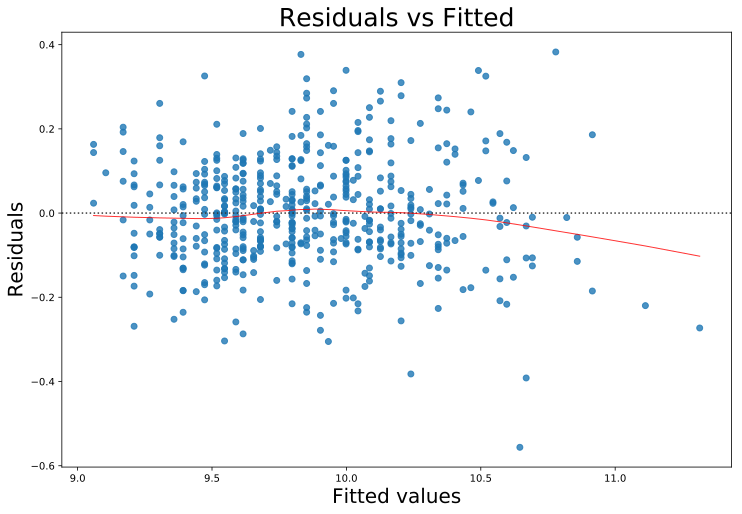

In [295]:
# Predict the RMSE in test data
y_test_predicted = model5_sm.predict(sm.add_constant(X_test_lasso_red))
score = np.sqrt(mean_squared_error(y_test_predicted, y_test_log))
print ('RMSE on test set is', score)

# Plot the residual plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)
sns.residplot(y_test_log, y_test_predicted, 
              lowess=True, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted', fontsize=25)
plot_lm_1.axes[0].set_xlabel('Fitted values', fontsize=20)
plot_lm_1.axes[0].set_ylabel('Residuals',  fontsize=20)
plot_lm_1.savefig('final-model-residual.png')

In [244]:
model5_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     238.6
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:10:19   Log-Likelihood:                 964.34
No. Observations:                1614   AIC:                            -1829.
Df Residuals:                    1564   BIC:                            -1559.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.5571      0.471     18.180      0.000       7.634       9.480
engine                    0.0345      0.011      3.021      0.003       0.012       0.057
cylinder                  0.0173      0.009      1.906      0.057      -0.001       0.035
horsepower                0.0002      0.000      0.516      0.606      -0.001       0.001
rating_2                 -0.0067      0.004     -1.796      0.073      -0.014       0.001
store[T.Fremont, CA]      0.0299      0.011      2.668      0.008       0.008       0.052
make[T.BMW]               0.0373      0.018      2.107      0.035       0.003       0.072
make[T.Chrysler]         -0.1337      0.028     -4.716      0.000      -0.189      -0.078
make[T.Dodge]            -0.2671      0.021    -12.991      0.000      -0.307      -0.227
make[T.Ford]             -0.0488      0.013     -3.820      0.000      -0.074      -0.024
make[T.GMC]              -0.1364      0.033     -4.110      0.000      -0.201      -0.071
make[T.Honda]             0.1623      0.017      9.729      0.000       0.130       0.195
make[T.Hyundai]          -0.0329      0.016     -2.042      0.041      -0.064      -0.001
make[T.Infiniti]         -0.0924      0.025     -3.701      0.000      -0.141      -0.043
make[T.Jaguar]            0.1071      0.042      2.576      0.010       0.026       0.189
make[T.Land]              0.1795      0.033      5.416      0.000       0.115       0.245
make[T.Lexus]             0.1010      0.026      3.894      0.000       0.050       0.152
make[T.Mazda]             0.0761      0.022      3.410      0.001       0.032       0.120
make[T.Mini]              0.0863      0.030      2.919      0.004       0.028       0.144
make[T.Nissan]           -0.0831      0.015     -5.517      0.000      -0.113      -0.054
make[T.Porsche]           0.3580      0.049      7.332      0.000       0.262       0.454
make[T.Subaru]            0.1376      0.030      4.620      0.000       0.079       0.196
make[T.Toyota]            0.1514      0.019      7.851      0.000       0.114       0.189
make[T.Volkswagen]       -0.1601      0.018     -8.888      0.000      -0.195      -0.125
age                       0.0094      0.019      0.506      0.613      -0.027       0.046
mileage                  -0.0066      0.002     -3.839      0.000      -0.010      -0.003
highway                  -0.0249      0.005     -4.548      0.000      -0.036      -0.014
drive                    -0.2380      0.056     -4.279      0.000      -0.347      -0.129
city                      0.0252      0.002     10.281      0.000       0.020       0.030
torque                    0.0040      0.001      4.016      0.000       0.002       0.006
age^2                    -0.0012      0.001     -2.013      0.044      -0.002   -3.12e-05
age highway            

In [247]:
model5_pvalues = pd.DataFrame(list(zip(model5_sm.pvalues.index.tolist(), model5_sm.params, model5_sm.pvalues)), columns = ['variable', 'coefficient', 'p-value'])                         

In [250]:
model5_pvalues[model5_pvalues['p-value']<0.05].sort_values('coefficient', ascending=False)

,variable,coefficient,p-value
0,const,8.557074,3.759057e-67
20,make[T.Porsche],0.358043,3.630225e-13
15,make[T.Land],0.179524,7.036356e-08
48,luxury,0.169592,4.970133e-28
11,make[T.Honda],0.162316,9.266105e-22
22,make[T.Toyota],0.151437,7.628877e-15
21,make[T.Subaru],0.137625,4.154064e-06
14,make[T.Jaguar],0.107140,1.009596e-02
16,make[T.Lexus],0.100981,1.027759e-04
18,make[T.Mini],0.086260,3.559954e-03


In [251]:
model5_pvalues[model5_pvalues['p-value']>=0.05].sort_values('coefficient', ascending=False)

,variable,coefficient,p-value
46,torque_log,0.091226,0.556084
47,horsepower_log,0.078566,0.451033
2,cylinder,0.017311,0.056865
42,drive city,0.010124,0.055595
24,age,0.009429,0.612830
32,age drive,0.005284,0.406546
3,horsepower,0.000233,0.605854
35,mileage highway,0.000056,0.110046
37,mileage torque,-0.000002,0.488524
36,mileage drive,-0.000524,0.315572


In [ ]:
Toyota = X_test_norm